# Ponavljajoča nevronska mreža za izris polinomov

To je drugi testni primer ponavljajoče nevronske mreže (RNN - ang. recurrent neural network), ki je smiselno nadaljevanje [prvega](https://github.com/jborlinic/machine_learning/blob/master/STS_sintetic/RNN%20za%20dokon%C4%8Danje%20izrisov%20grafov%20kvadratnih%20funkcij.ipynb). Končna ideja ostaja enaka, da bomo znali izdelati bolj kompleksen model za predvidevanje (dopolnjevanje) neke GPS sledi.

Za nabor podatkov bomo tokrat zgenerirali točkovna zaporedja grafov  polinomov in jih pretvorili v smiselno strukturo, ki se sklada z našimi podatki za GPS sledi. Tako bo nevronska mreža kot vhodni podatek prejela $15$ zaporednih točkah in kot izhodni podatek naslednjih $5$. 

To bo naš drugi nabor podatkov za STS (_ang. Sequence To Sequence_) model, ki bo znal dopolniti/izrisati graf kvadratnih funkcij in kasneje GPS sledi.

## Generiranje in predprocesiranje podatkov

Zgenerirajmo 100000 naključnih polinomov s pomočjo osnovne ničelne enačbe za polinome s petimi ničlami:  $f = a(x-x_0)\cdot b(x-x_1)\cdot c(x-x_2)\cdot d(x-x_3)\cdot e(x-x_4)$, kjer so $x_0,x_1, x_2, x_3, x_4 \in [10,80]$ poljubne ničle polinoma in $a,b,c,d,e \in \{-1,1\}$.  

Ti pogoji nam zgenerirajo poljubne polinome.  

Ker želimo, da se model nauči čim bolj splošne polinome, vzamemo $25$ zaporednih točk vsake kvadratne funkcije.  
Kasneje bomo ta zaporedja $25$ točk razbili na $25 - 20 = 5$ podzaporedij, jih normirali na interval $[0,1]\times[0,1]$ in razdelili v trening, validacijski in testni nabor podatkov. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_polinomial_data(n_to_gen, finess=50, show_graphs=False):
    """
    A method that generates n_to_gen polinomials with finess number of points equaly displaced on 
    the interval (0,100).
    Parameters:
        - n_to_gen (int), number of polinomials to generate
        - finess (int), the number of points for each polinomial
        - show_graph (bool), if the function should also print the generated polinomials
    """
    x = np.arange(finess)
    x = x / (finess / 100)
    data = []
    for _ in range(n_to_gen):
        x0 = np.random.randint(80) + 10
        x1 = np.random.randint(80) + 10
        x2 = np.random.randint(80) + 10
        x3 = np.random.randint(80) + 10
        x4 = np.random.randint(80) + 10
        
        #print(x0, x1, x2, x3, x4)
        p =(np.power(-1, x0) * (x - x0) * 
            np.power(-1, x1) * (x - x1) * 
            np.power(-1, x2) * (x - x2))# * 
            #np.power(-1, x3) * (x - x3) *
            #np.power(-1, x4) * (x - x4))
        
        x = np.reshape(x, (-1,1))
        y = np.reshape(p, (-1,1))
    
        points = np.append(x, y, axis=1)
        
        if show_graphs:
            plt.scatter(points[:,0], points[:,1])
            plt.show()
              
        data.append(points)
        
    return np.array(data)

In [2]:
def normalize(data):
    """
    Method that normalizes the generated quadratic function data.
    Parameters:
        - data, (np.array of shape (n_of_functions, n_of_points, 2))
    """
    for i in range(2):
        maxI = np.amax(data[:,:,i])
        minI = np.amin(data[:,:,i])
        data[:,:,i] = (data[:,:,i] - minI) 
        data[:,:,i] = data[:,:,i] / (maxI - minI)
    
    return data

Podobno kot v prejšnjem primeru s pomočjo zgoraj definiranih metod v naslednji vrstici zgeneriramo $100000$ polinomov, kjer ima vsak od njih $25$ točk.  
Seveda nočemo, da metoda vse polinome izriše, vseeno pa želimo izrisati par polinomov, da vidimo, če imamo dobro zgenerirane podatke (to storimo v naslednji (for) zanki, kjer izrišemo $5$ naključno izbranih vrstic iz našega zgeneriranega nabora podatkov).

In [3]:
gen_data = normalize(generate_polinomial_data(100000, finess=25, show_graphs=False))

print(gen_data.shape)

(100000, 25, 2)


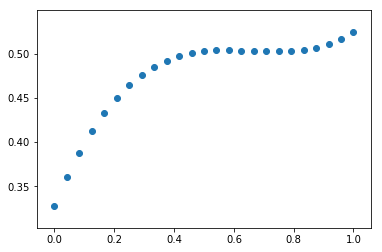

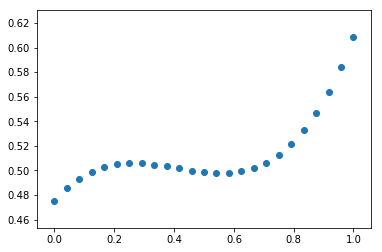

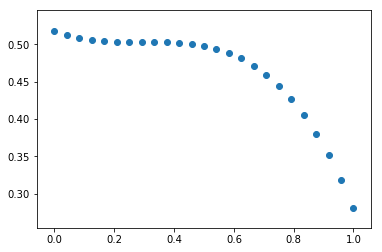

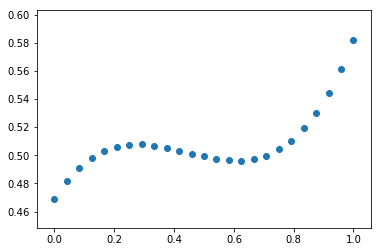

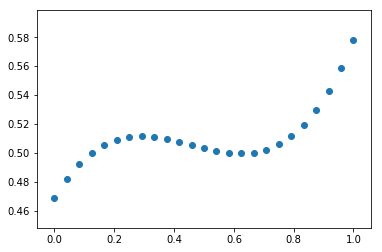

In [4]:
for _ in range(5): # spremeni range(5), ce zelis vec ali manj izrisanih grafov
    a = np.random.randint(gen_data.shape[0])
    points = gen_data[a]
    plt.scatter(points[:,0], points[:,1])
    plt.show()

Po izrisanih grafih lahko sklepamo, da zgornje metode zgenerirajo dober nabor podatkov.  

Naslednji korak je pretvorba posameznega zaporedja s $25$ točkami v $5$ dvodelnih podzaporedij iz $15$ zaporednih točk in naslednjih $5$ zaporednih točk. Ta razdelitev nam pripravi podatke v takšno obliko, kot jo bomo potrebovali v modelu. Torej model, ki prejme $15$ točk in predvidi naslednjih $5$. Zanj potrebujemo primerne vhodne in izhodne podatke.  
To pretvorbo nam opravijo naslednje funkcije.

In [5]:
def partition_data(data, ts_in, ts_out):
    """
    The method partitions the "track" data of shape (n_of_tracks, n_of_points_per_track, n_of_dim_per_point) into 
    two datasets of tracks representing the input and output of our model, with length ts_in and ts_out respectively.
    Parameters:
        - data (np.array), the dataset to be partitioned of shape (n_of_tracks, n_of_points_per_track, n_of_dim_per_point)
        - ts_in (int), length of the needed input dataset
        - ts_out (int), length of the needed output dataset

    NOTE: ts_in + ts_out < n_of_points_per_track
    """
    print(data.shape)
    data_in = []
    data_out = []
    r = data.shape[1]
    for f in data:
        for i in range(r//(ts_in + ts_out)):
            new_in = f[i:i + ts_in]
            new_out = f[i + ts_in:i + ts_in + ts_out]
            data_in.append(new_in)
            data_out.append(new_out)
            
    data_in = np.array(data_in)
    data_out = np.array(data_out)
    
    return data_in, data_out
    
data_in, data_out = partition_data(gen_data, 15, 5)

(100000, 25, 2)


Zadnja dva koraka pri pripravi podatkov sta naslednja:
- razdelitev v tri množice (učenje, validacija, test),  
želimo, da je ta razdelitev naključna in procentualno razdeljena ($80%$, $10%$, $10%$).
- pridobljene podatke želimo shraniti v direktorij: ../.datasets/sintetic_STS/polinomials/


In [6]:
def split_data(data, train_per=0.8, val_per=0.1, test_per=0.1):
    """
    The method splits our dataset over axis=0 into three datasets, training data, validation data and test data.
    Parameters:
        - data (np.array), the dataset to be split,
        - train_per (float), the % of the data to be used for the training set,
        - val_per (float), the % of the data to be used for the validation set,
        - test_per (float), the % of the data to be used for the test set.
    """
        
    train_ind = int(data.shape[0] * train_per)
    val_ind = int(data.shape[0] * (train_per + val_per))
    train_data = data[:train_ind]
    val_data = data[train_ind:val_ind]
    test_data = data[val_ind:]
    
    return train_data, val_data, test_data

In [7]:
# The directory to save the datasets.
DATA_DIR = '../.datasets/sintetic_STS/polinomials/'

train_data_in, val_data_in, test_data_in = split_data(data_in)
train_data_out, val_data_out, test_data_out = split_data(data_out)

np.save('%strain_data_in.npy' %DATA_DIR, train_data_in)
np.save('%sval_data_in.npy' %DATA_DIR, val_data_in)
np.save('%stest_data_in.npy' %DATA_DIR, test_data_in)

np.save('%strain_data_out.npy' %DATA_DIR, train_data_out)
np.save('%sval_data_out.npy' %DATA_DIR, val_data_out)
np.save('%stest_data_out.npy' %DATA_DIR, test_data_out)

In [ ]:
# This cell is here only for the second, third, ... pass through the code. 
# If we have allready genereated our data sets we can just read them instead of going through the former process again.
DATA_DIR = '../.datasets/sintetic_STS/polinomials/'

train_data_in = np.load('%strain_data_in.npy' %DATA_DIR)
val_data_in = np.load('%sval_data_in.npy' %DATA_DIR)
test_data_in = np.load('%stest_data_in.npy' %DATA_DIR)

train_data_out = np.load('%strain_data_out.npy' %DATA_DIR)
val_data_out = np.load('%sval_data_out.npy' %DATA_DIR)
test_data_out = np.load('%stest_data_out.npy' %DATA_DIR)

## STS model
STS (ang. _sequence to sequence_) modeli so namenjeni predvsem za delo z zaporednimi nabori podatkov. So specifični primer RNN (recurrsive neural network) ponavljajočih nevronskih mrež, kjer model vrača zaporedje in ne le ene vrednosti.  

Podrobneje so opisani na [Microsoft GitHubu za STS modele v CNTK](https://github.com/Microsoft/CNTK/wiki/Sequence-to-Sequence-%E2%80%93-Deep-Recurrent-Neural-Networks-in-CNTK-%E2%80%93-Part-1).  

Spodaj je izdelan model, ki zna napovedat naslednjih $5$ točk zaporedja na podlagi prejšnjih $15$ točk. Tako, kot vhodni podatek prejme 3-D matriko naslednje oblike: (št. primerov, $15$-točk, $2$-koordinati).

In [8]:
import keras
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, RepeatVector


Using TensorFlow backend.


### Definicija modela
Definirajmo zaporedni model, sestavljen iz kodirnika (_ang. encoder_), nekaj vmesnih slojev in dekodirnika (_ang. decoder_).

Kodirnik sestavlja _hidden_neurons ($=1000$)_ [LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) nevronov, nato imamo polnopovezan sloj ($1000 \times 1000$) z aktivacijsko funkcijo [ReLu](https://www.mathworks.com/help/nnet/ref/relulayer-class.html?requestedDomain=www.mathworks.com), nato osipni (_ang. dropout_) sloj s $50%$ propustnostjo. Sledi repeat vektor, ki skopira izhod kodirnika $5$ krat, s tem dobimo vhod za dekodirnik. Dekodirnik je sestavljen iz _hidden_neurons ($=1000$)_ [LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) nevronov in za konec izhod dekodirnika ($5$ zaporednih vrednosti) s pomočjo time distributed okvirja (vsako vrednost posebej) spustimo skozi polnopovezan sloj in tako dobimo $5$ naslednjih(napovedanih) točk, ki jih med učenjem primerjamo z realnimi.

In [9]:
def seqToSeq_model(n_of_features, input_sequence_length, output_sequence_length):
    
    hidden_neurons = 1000
    model = keras.models.Sequential()

    ##Encoder
    model.add(LSTM(hidden_neurons,
              input_shape=(input_sequence_length, n_of_features),
              return_sequences=False
              ))
    print(model.outputs)
    model.add(Dense(hidden_neurons, activation='relu'))
    model.add(Dropout(0.5))

    print(model.outputs)
    model.add(RepeatVector(output_sequence_length))
    print(model.outputs)
    
    ##Decoder
    model.add(LSTM(hidden_neurons,
              return_sequences=True))

    print(model.outputs)
    model.add(TimeDistributed(Dense(n_of_features, activation='relu')))
    print(model.outputs)

    return model

V testne namene sem uporabljal tudi navadno globoko nevronsko mrežo, sestavljeno iz $17$ ih slojev:  
- sploščitveni sloj [ang. _flatten_] ($25 \times 2 > 50$),
- polnopovezan sloj [ang. _dense_] ($50 > 256$) z aktivacijo [tanh](http://mathworld.wolfram.com/HyperbolicTangent.html),
- osipni sloj [ang._dropout_] ($50%$ ohranitve),
- polnopovezan sloj [ang. _dense_] ($256 > 1024$) z aktivacijo [tanh](http://mathworld.wolfram.com/HyperbolicTangent.html),
- osipni sloj [ang. _dropout_] ($50%$ ohranitve),
- polnopovezan sloj [ang. _dense_] ($1024 > 2048$) z aktivacijo [tanh](http://mathworld.wolfram.com/HyperbolicTangent.html),
- osipni sloj [ang. _dropout_] ($50%$ ohranitve),
- polnopovezan sloj [ang. _dense_] ($2048 > 4096$) z aktivacijo [tanh](http://mathworld.wolfram.com/HyperbolicTangent.html),
- osipni sloj [ang. _dropout_] ($50%$ ohranitve),
- polnopovezan sloj [ang. _dense_] ($4096 > 2048$) z aktivacijo [tanh](http://mathworld.wolfram.com/HyperbolicTangent.html),
- osipni sloj [ang._dropout_] ($50%$ ohranitve),
- polnopovezan sloj [ang. _dense_] ($2048 > 1028$) z aktivacijo [tanh](http://mathworld.wolfram.com/HyperbolicTangent.html),
- osipni sloj [ang. _dropout_] ($50%$ ohranitve),
- polnopovezan sloj [ang. _dense_] ($1028 > 256$) z aktivacijo [tanh](http://mathworld.wolfram.com/HyperbolicTangent.html),
- osipni sloj [ang. _dropout_] ($50%$ ohranitve),
- polnopovezan sloj [ang. _dense_] ($256 > 10$),
- preoblikovalni sloj [ang. _reshape_] ($10 > 5 \times 2$).

In [10]:
"""
This model was used for testing purposes during implementation. Now it is unused.

from keras.layers import Dense, Dropout, Flatten, Reshape

def dNN_model(n_of_features, input_sequence_length, output_sequence_length):
    
    
    model = keras.models.Sequential()
    model.add(Flatten(input_shape=(input_sequence_length, n_of_features)))
    ##Encoder
    model.add(Dense(256,
              activation='tanh'
              ))
    #print(model.outputs)
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='tanh'))
    model.add(Dropout(0.5))

    #print(model.outputs)
    model.add(Dense(2048, activation='tanh'))
    model.add(Dropout(0.5))
    
    model.add(Dense(4096, activation='tanh'))
    model.add(Dropout(0.5))
    
    model.add(Dense(2048, activation='tanh'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1028, activation='tanh'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='tanh'))
    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='tanh'))
    model.add(Reshape((5,2)))
    
    return model
"""

Ko bomo model natrenirali ga želimo shraniti in ko bomo imeli že obstoječ model shranjen, želimo imeti možnost, da ga iz datoteke preberemo.  
To storita naslednji metodi.

In [1]:
def load_model(model_dir):
    """
    This method loads a previously traned model from model_dir.
    Parameters:
        - model_dir (string), a directory where the model and its weights are saved.
    """
    try:
        f = open('%smodel' %model_dir, 'r')
        json_string = f.read()

        model = model_from_json(json_string)
        model.load_weights('%sweights' %model_dir)
        print('Model loaded!')

        return model

    except FileNotFoundError:
        print('Could not load model!')


def save_model(model_dir, model):
    """
    This method saves the model to the model_dir directory.
    Properties:
        - model (keras.model), a trained keras model,
        - model_dir (string), the directory to save the model to.
    """
    json_string = model.to_json()

    f = open('%smodel' %model_dir, 'w+')
    f.write(json_string)
    f.close()

    model.save_weights('%sweights' %model_dir)
    print("Model saved!")


Čas je, da naš model nekaj naučimo.  
Za to potrebujemo naložen model, ki ga moremo kompilirati (pripraviti) s funkcijo izgube (_ang. loss function_) in optimizatorjem (v tem primeru Adam).  
Z metodo fit nato model učimo.

In [12]:
MODEL_DIR = 'model/polinomial/'

model = seqToSeq_model(2, 15, 5)
#model = dNN_model(2, 15, 5)

model.compile(loss='mean_squared_error', optimizer='Adam')
model.fit(train_data_in, train_data_out, epochs=10, batch_size=100, validation_data=(val_data_in, val_data_out))

[<tf.Tensor 'lstm_1/TensorArrayReadV3:0' shape=(?, 1000) dtype=float32>]
[<tf.Tensor 'dropout_1/cond/Merge:0' shape=(?, 1000) dtype=float32>]
[<tf.Tensor 'repeat_vector_1/Tile:0' shape=(?, 5, 1000) dtype=float32>]
[<tf.Tensor 'lstm_2/transpose_1:0' shape=(?, ?, 1000) dtype=float32>]
[<tf.Tensor 'time_distributed_1/Reshape_1:0' shape=(?, 5, 2) dtype=float32>]
Train on 80000 samples, validate on 10000 samples
Epoch 1/10
80000/80000 [==============================] - 179s - loss: 0.0021 - val_loss: 2.3557e-04
Epoch 2/10
80000/80000 [==============================] - 137s - loss: 2.5346e-04 - val_loss: 2.5629e-04
Epoch 3/10
80000/80000 [==============================] - 137s - loss: 2.4522e-04 - val_loss: 2.2729e-04
Epoch 4/10
80000/80000 [==============================] - 137s - loss: 2.4589e-04 - val_loss: 2.4154e-04
Epoch 5/10
80000/80000 [==============================] - 137s - loss: 2.4447e-04 - val_loss: 2.2295e-04
Epoch 6/10
80000/80000 [==============================] - 137s - los

Metoda model.predict je namenjena napovedovanju vrednosti s pomočjo naučenega modela. To seveda želimo narediti na validacijskem (ali testnem) naboru podatkov. Predikcije želimo tudi vizualizirati, kar stori for zanka (ta izriše $50$ kvadratnih funkcij, kjer je vhodni del zaporedja modre barve, z rdečo je izrisan izhodni del(realni) z zeleno pa napoved modela).

In [13]:
#model.fit(train_data_in, train_data_out, epochs=5, batch_size=100, validation_data=(val_data_in, val_data_out))

#model = load_model('model_DNN/')
#model.compile(loss='mean_squared_error', optimizer='Adam')

pred = model.predict(val_data_in)

7557


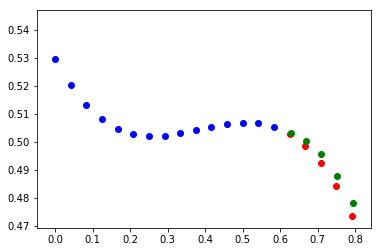

2603


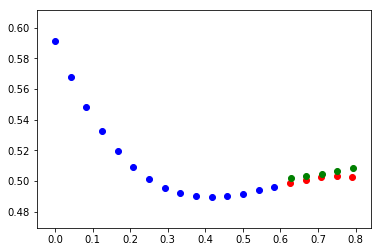

8013


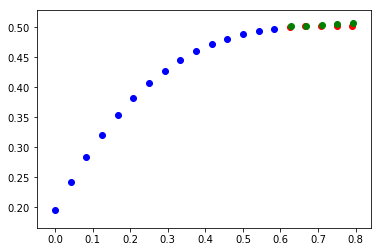

2281


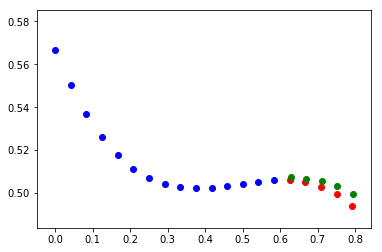

8649


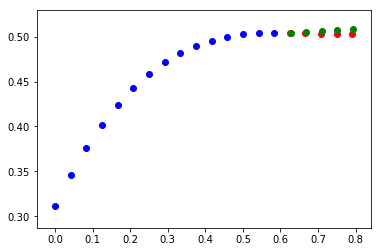

2756


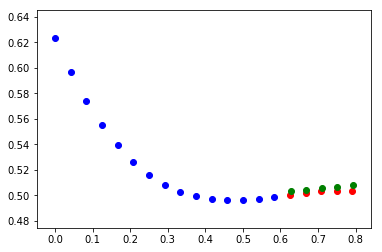

3105


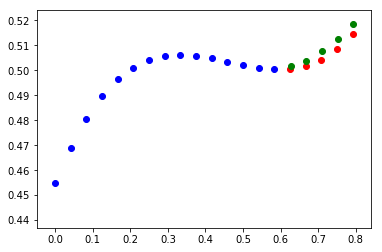

8219


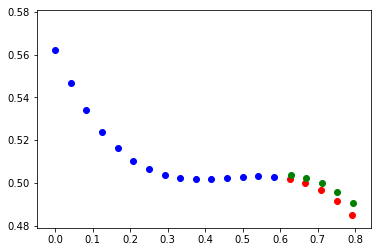

2264


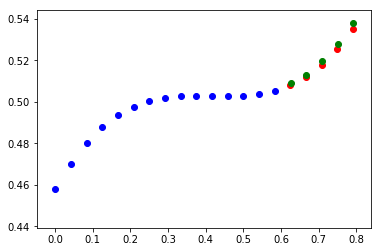

7732


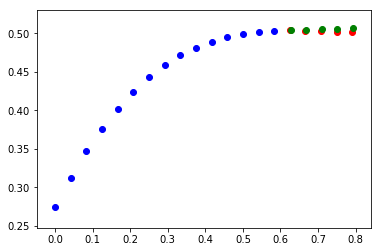

155


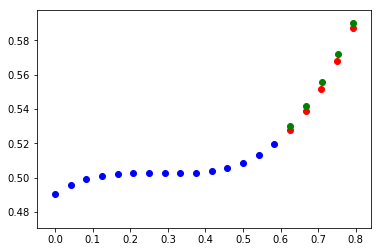

4495


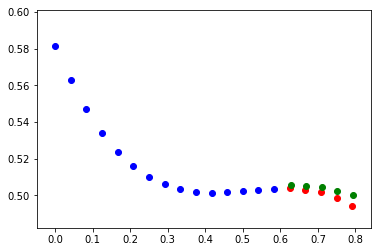

7276


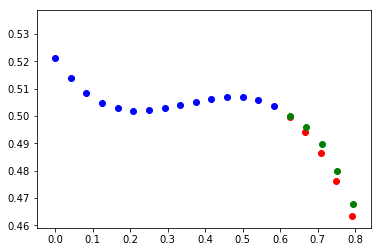

7204


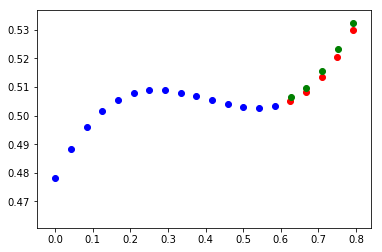

1106


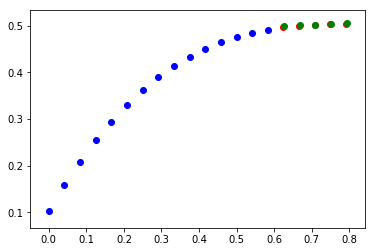

5555


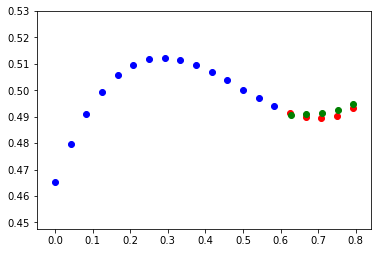

7291


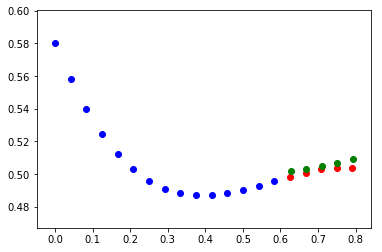

9064


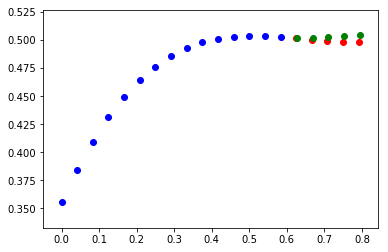

1587


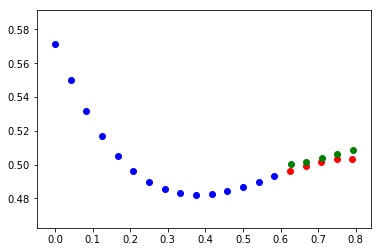

6457


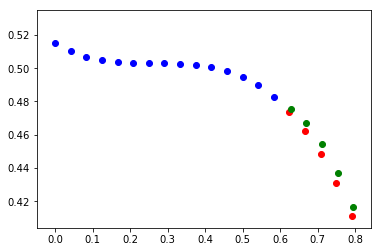

5466


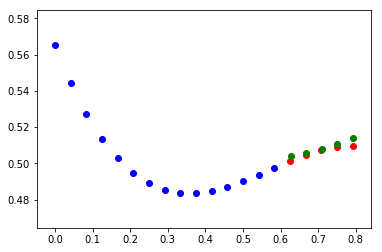

6488


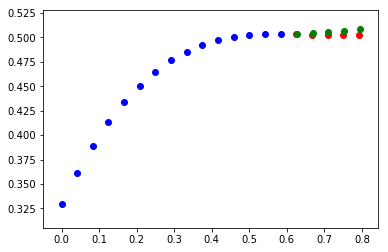

6820


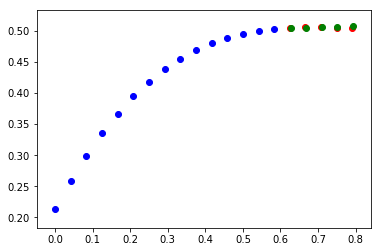

1287


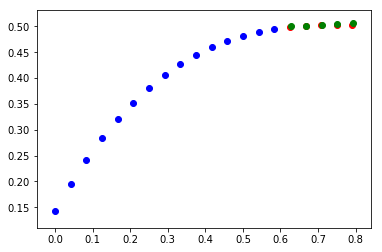

4257


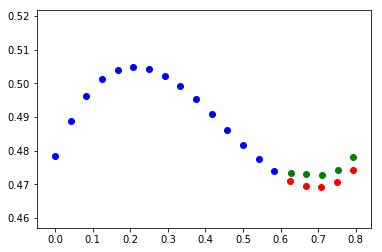

8711


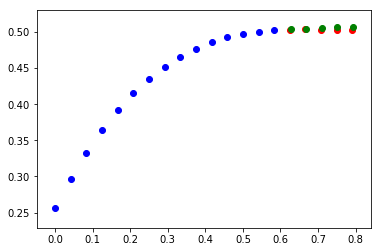

1790


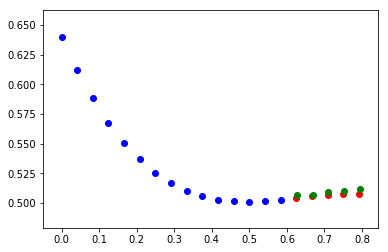

6635


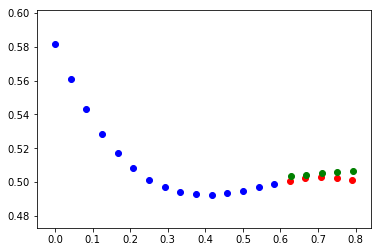

5898


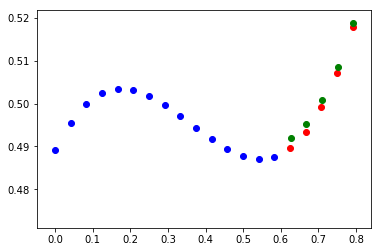

9843


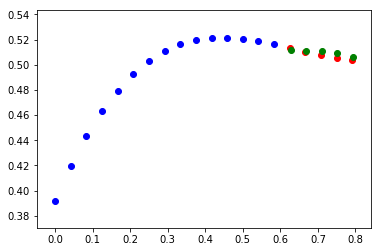

7448


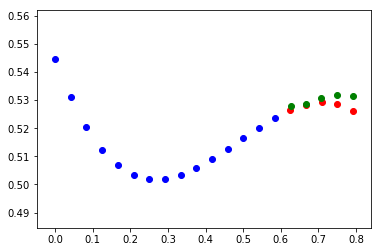

7692


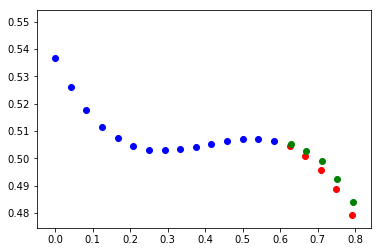

2286


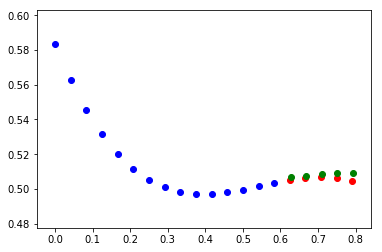

8705


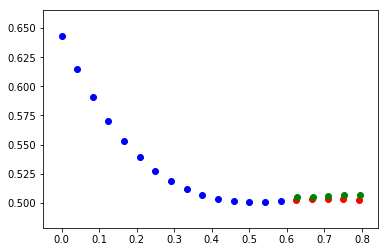

6445


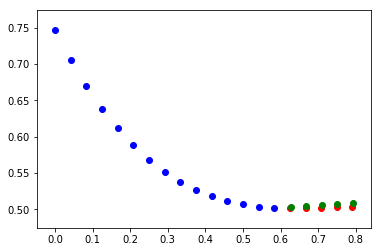

9199


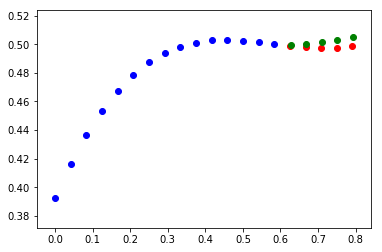

1556


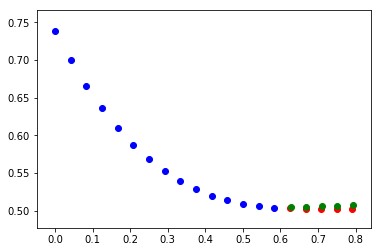

7385


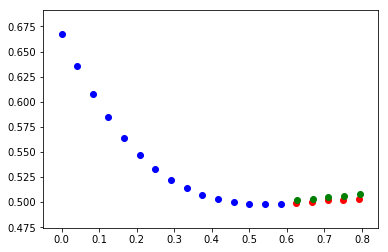

9549


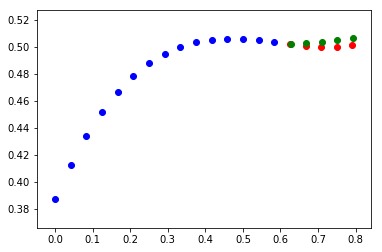

7785


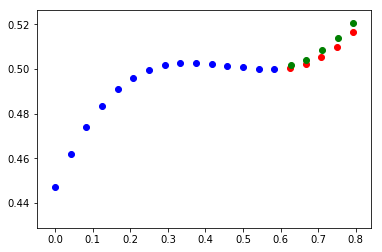

7641


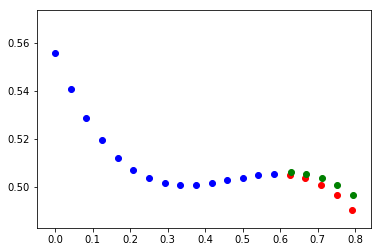

1071


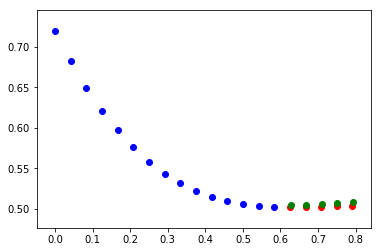

4441


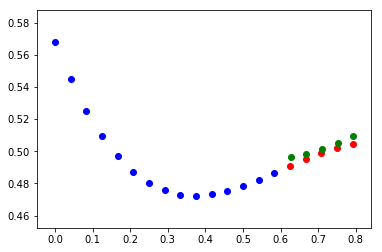

1971


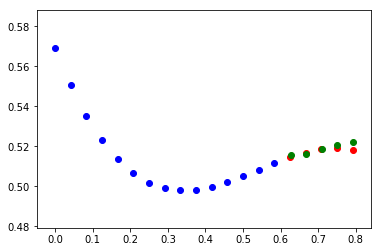

1082


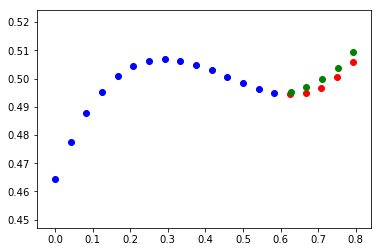

5921


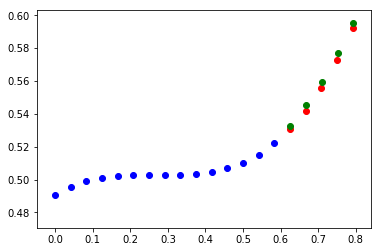

6776


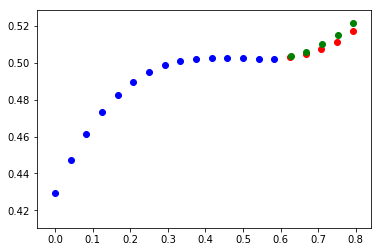

7423


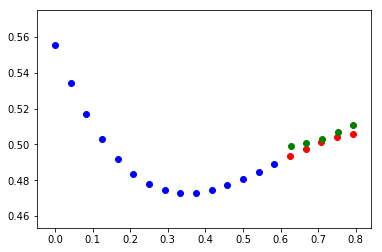

5450


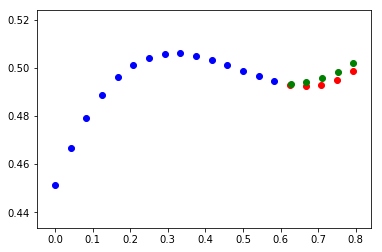

8150


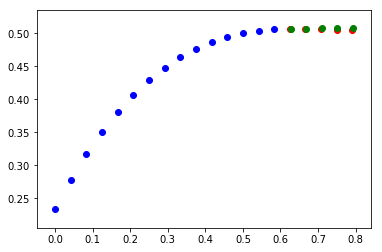

In [14]:
for _ in range(50):
    i = np.random.randint(val_data_in.shape[0])
    print(i)
    plt.scatter(val_data_in[i,:,0],val_data_in[i,:,1], color='blue')
    plt.scatter(val_data_out[i,:,0],val_data_out[i,:,1], color='red')
    plt.scatter(pred[i,:,0], pred[i,:,1], color='green')
    plt.show()

Na zgornjih primerih je razvidno, da se je model po $10$ prehodih čez učni nabor podatkov zelo dobro naučil prepoznavati polinome (s pomočjo $15$ točk napovedati naslednjih $5$). Še posebej zanimivi so primeri, kjer more model napovedati obnašanje polinoma v ekstremu, te točke so izjemno zanimive, saj le poznavanje detaljne strukture polinoma omogoča dobre rezultate pri takšnih napovedih.  

Za konec še shranimo naš naučen model s pomočjo funkcije save_model.

In [15]:
save_model('model_RNN/polinomial/', model)
#save_model('model_RNN/quad_funct/', model)


Model saved!
